# Classifiers workshop

In this workshop we will continue working with calcium imaging data. 

In the calcium workshop you learned about the Peri-Stimulus Time Histogram. Again, PSTH is a way to visualize the average neural response aligned to a specific event like the stimulus onset, reward, or a behavioral cue.

 But when you have hundreds of neurons over several trials, visualising one by one and deciding what is the most likely function is extremely time consuming and inefficient. Luckily there are several approaches that we can use to classify the neurons, using machine learning techniques we learned during the lectures. 

In [ ]:
#random forest with lookup table
#t-sne


In [ ]:
%pip install umap-learn
%pip install scipy 

In [ ]:
%pip install plotly
%pip install nbformat --upgrade
%pip install jupyterlab "ipywidgets>=7.5"


In [5]:
#import and load the right libraries

import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.integrate
from scipy.integrate import simpson
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


First, we are going to consolidate what we learned in the calcium data analysis workshop. Let's build a pipeline to sort the neuron responses into its 4 different categories. 
We will then learn how to extract meaningful features. 

In [6]:
# we are going to create a dataset with the information we need

data_directory = "S1_trained" # Path to our dataset
output_csv_stats = "neuron_response_features.csv"
output_csv_raw_psths = "neuron_responses_raw.csv"


neuron_features = []

neuron_features_raw= []



for neuron_file in os.listdir(data_directory):
    if not neuron_file.endswith('.mat'):
        continue

    mat = loadmat(os.path.join(data_directory, neuron_file))

    
    # load the variables
    dff = mat['dff'].flatten()
    cues = mat['cues'].flatten()
    reward = mat['reward'].flatten()
    punish =mat['punish'].flatten()
    go= mat['go'].flatten()
    nogo= mat['nogo'].flatten()

    stimtimes = list(np.where(cues ==1)[0])

    # get the number of trials 
    numtrials = len(stimtimes)

    # get the duration of the trial.  The trial duration is the time between one stimulus and the other. 
    #think about it, you have a list of time points where the cues happen. How can you get the amount of time between one cue and the next? 
    trial_duration = stimtimes[1] - stimtimes[0]  # assumes constant duration

    baseline = 2
    post_stim_period = trial_duration - baseline - 1


    # Allocate Containers
    hit_waves = []
    miss_waves = [] 
    fa_waves = [] 
    cr_waves = [] 


    # Sort Trials by Type

    #set the counter to all these to 0
    hit = 0
    miss = 0
    fa = 0
    cr = 0

    for itrial in range(numtrials - 1):
        
        istimstart = stimtimes[itrial] # time of the current trial
        next_stim = stimtimes[itrial + 1] # time of the next trial
        start_idx = istimstart - baseline
        end_idx = istimstart + post_stim_period

        #segment of dff
        segment = dff[start_idx:end_idx]

        # checks if the stimulus is Go
        if go[istimstart] == 1:
            # if the stimulus is Go and there is a reward, it means that the mouse licked for the right stimulus! Hurrah!
            if np.any(reward[istimstart:next_stim] ==1 ):
                hit_waves.append(segment)
                hit+=1
            else:
            #if the stimulus is Go and the mouse did not get a reward, it's a miss
                miss_waves.append(segment)
                miss+=1

        # check if the stimulus is NoGo
        elif nogo[istimstart] ==1:
            # if the mouse was punished, it means it licked, therefore false alarm
            if np.any(punish[istimstart:next_stim] ==1 ):
                fa_waves.append(segment)
                fa+=1
            else:
            # otherwise it correctly rejected the NoGo stimulus
                cr_waves.append(segment)
                cr+=1


    #  Lick-Aligned Waveforms

    # both hit and fa involve the mouse licking (miss and correct rejections means that the mouse doesn't lick)
    hit_lick_waves = []
    fa_lick_waves = []

    #same thing as before 
    for itrial in range(1, numtrials - 1):
        istimstart = stimtimes[itrial]
        next_stim = stimtimes[itrial + 1]
        
    # here it's a bit different, but we basically get whether the mouse was rewarded (aka licked correctly)
        if go[istimstart] == 1:
            licktimes = np.where(reward[istimstart:next_stim] > 0)[0] # the reward is given if the mouse licks correctly 
            if len(licktimes) > 0:
                lick_index = istimstart + licktimes[0]
                start = lick_index - trial_duration // 2
                end = lick_index + trial_duration // 2
                segment = dff[start:end]
                #print(lick_index, licktimes, licktimes[0])

                hit_lick_waves.append(segment)
        #or we get whether the mouse was punished (licked but shouldn't have)
        elif nogo[istimstart] > 0:
            licktimes = np.where(punish[istimstart:next_stim] > 0)[0]
            if len(licktimes) > 0:
                lick_index = istimstart + licktimes[0]
                start = lick_index - trial_duration // 2
                end = lick_index + trial_duration // 2
                segment = dff[start:end]
                fa_lick_waves.append(segment)



    hit_lick_waves = np.array(hit_lick_waves).T if hit_lick_waves else np.empty((trial_duration, 0))
    fa_lick_waves = np.array(fa_lick_waves).T if fa_lick_waves else np.empty((trial_duration, 0))



    # we are now writing a function that takes the waves and computes important information such as psth, the peak of the wave, the area under the curve (auc), and the latency at which the peak occurs. 

    
    def compute_features(waves):
        if len(waves) == 0:
            return np.zeros(post_stim_period + baseline), 0, 0, 0
        psth = np.mean(waves, axis=0)
        peak = np.max(psth)
        auc = simpson(psth)
        latency = np.argmax(psth)
        return psth, peak, auc, latency 

    hit_psth, hit_peak, hit_auc, hit_latency = compute_features(hit_waves)
    miss_psth, miss_peak, miss_auc, miss_latency  = compute_features(miss_waves)
    fa_psth, fa_peak, fa_auc, fa_latency  = compute_features(fa_waves)
    cr_psth, cr_peak, cr_auc, cr_latency  = compute_features(cr_waves)


    # dataset 1: RAW PSTHs
    # Concatenate all PSTHs a
    raw_vector = np.concatenate([hit_psth, miss_psth, fa_psth, cr_psth])
    neuron_features_raw.append({'neuron_id': neuron_file, 'features': raw_vector})


   # dataset 2: features extracted from the data
   #(peak, area under the curve, latency of the peak )
    
    neuron_features.append({
        'neuron_id': neuron_file,
        'hit_peak': hit_peak,
        'hit_auc': hit_auc,
        'hit_latency': hit_latency,
        'miss_peak': miss_peak,
        'miss_auc': miss_auc,
        "miss_latency": miss_latency,
        'fa_peak': fa_peak,
        'fa_auc': fa_auc,
        "fa_latency": fa_latency,
        'cr_peak': cr_peak,
        'cr_auc': cr_auc,
        "cr_latency":cr_latency
        })
    


#store the two different datasets 

raw_df = pd.DataFrame([{
    'neuron_id': entry['neuron_id'],
    **{f'feat_{i}': val for i, val in enumerate(entry['features'])}
} for entry in neuron_features_raw])

#print(raw_df)
raw_df.to_csv(output_csv_raw_psths , index=False)



df = pd.DataFrame(neuron_features)
print(df)
df.to_csv(output_csv_stats, index=False)
print(f"Feature extraction complete. Saved to {output_csv_stats}")



                           neuron_id  hit_peak   hit_auc  hit_latency  \
0    0301_20180323_11_timeseries.mat  0.420175  6.460560           15   
1    0301_20180323_12_timeseries.mat  0.084557  0.517923            7   
2    0301_20180323_15_timeseries.mat  0.256092  4.724933           15   
3    0301_20180323_17_timeseries.mat  0.245114  2.727329           38   
4    0301_20180323_18_timeseries.mat  0.171921  2.504394           10   
..                               ...       ...       ...          ...   
310  1140_20190614_74_timeseries.mat  0.040451  0.316291            2   
311   1140_20190614_7_timeseries.mat  0.199016  3.010162           26   
312  1140_20190614_80_timeseries.mat  0.054796  0.733749            8   
313   1140_20190614_8_timeseries.mat  0.123681  0.867478           21   
314   1140_20190614_9_timeseries.mat  0.328444  2.543636            7   

     miss_peak  miss_auc  miss_latency   fa_peak    fa_auc  fa_latency  \
0     0.200801 -3.679007            30  0.366290 

In [7]:
summary_df = pd.read_csv("neuron_response_features.csv")
summary_df[['hit_peak', 'miss_peak', 'fa_peak','cr_peak', "hit_latency","miss_latency","fa_latency","cr_latency","hit_auc","miss_auc","fa_auc", "cr_auc"]].describe()

,hit_peak,miss_peak,fa_peak,cr_peak,hit_latency,miss_latency,fa_latency,cr_latency,hit_auc,miss_auc,fa_auc,cr_auc
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.376082,0.373183,0.353778,0.311394,17.063492,16.895238,15.295238,15.869841,5.067961,2.904298,4.397056,3.107194
std,0.625157,0.743181,0.585824,0.582245,10.727477,11.568068,9.480040,10.677923,10.441004,9.532448,8.893272,8.252977
min,0.015109,0.028066,0.009097,0.000000,0.000000,0.000000,0.000000,0.000000,-3.227598,-5.344583,-3.381049,-2.493996
25%,0.081566,0.116011,0.075272,0.077987,9.000000,7.000000,9.000000,8.000000,0.490853,0.079905,0.407379,0.120496
50%,0.171136,0.197288,0.151805,0.149501,14.000000,14.000000,13.000000,13.000000,1.633680,0.813000,1.530253,0.872475
75%,0.384452,0.373009,0.343798,0.291615,26.000000,27.000000,20.500000,24.000000,4.700608,2.522357,4.148943,2.689086
max,5.084145,10.603575,3.990983,5.746730,39.000000,39.000000,39.000000,39.000000,82.222510,136.415410,70.509690,89.894215


In [8]:
raw_df = pd.read_csv("neuron_responses_raw.csv")
raw_df.describe()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_150,feat_151,feat_152,feat_153,feat_154,feat_155,feat_156,feat_157,feat_158,feat_159
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,...,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.051845,0.047083,0.052156,0.047022,0.048792,0.057096,0.075467,0.111858,0.157314,0.180592,...,0.062968,0.056820,0.043584,0.041951,0.051513,0.045639,0.055236,0.045383,0.041036,0.043326
std,0.140012,0.118668,0.136669,0.111950,0.113050,0.119157,0.151588,0.222776,0.342816,0.419977,...,0.235517,0.231933,0.156844,0.140382,0.143880,0.160223,0.239741,0.173036,0.139907,0.122128
min,-0.137152,-0.125256,-0.090189,-0.088932,-0.127673,-0.083862,-0.132215,-0.126895,-0.188196,-0.205473,...,-0.215215,-0.250759,-0.191390,-0.337706,-0.158762,-0.197368,-0.261036,-0.210235,-0.206005,-0.154861
25%,-0.001757,-0.003994,-0.002917,0.002296,-0.002405,-0.002723,0.000036,0.003332,0.004921,0.005294,...,-0.014843,-0.017954,-0.018148,-0.017702,-0.014643,-0.016615,-0.017114,-0.016660,-0.019088,-0.017545
50%,0.020936,0.015922,0.017923,0.017738,0.018799,0.021231,0.028799,0.042201,0.052984,0.049176,...,0.016246,0.014026,0.007821,0.014131,0.016673,0.011427,0.014192,0.012009,0.014185,0.011134
75%,0.056837,0.054396,0.061062,0.052690,0.059522,0.074943,0.103069,0.127114,0.164768,0.169612,...,0.072037,0.063567,0.057173,0.059576,0.060832,0.056320,0.065626,0.060989,0.065929,0.068076
max,1.839405,1.146213,1.669132,1.251646,1.098121,1.163721,1.001846,1.545545,2.641714,2.885397,...,3.204736,3.298736,1.411743,0.896121,1.016709,1.958169,3.685140,2.256880,1.568304,0.912266


Now we should have a .csv file called _neuron_response_features.csv_ that should look like this:

`neuron_id,hit_peak,hit_auc,hit_latency,miss_peak,miss_auc,miss_latency,fa_peak,fa_auc,fa_latency,cr_peak,cr_auc,cr_latency
0301_20180323_11_timeseries.mat,0.28882639817612504,3.495106414292626,16,0.28882639817612504,3.495106414292626,16,0.28882639817612504,3.495106414292626,16,0.28882639817612504,3.495106414292626,16
`


Let's see if we can get anything meaningful out of it! 



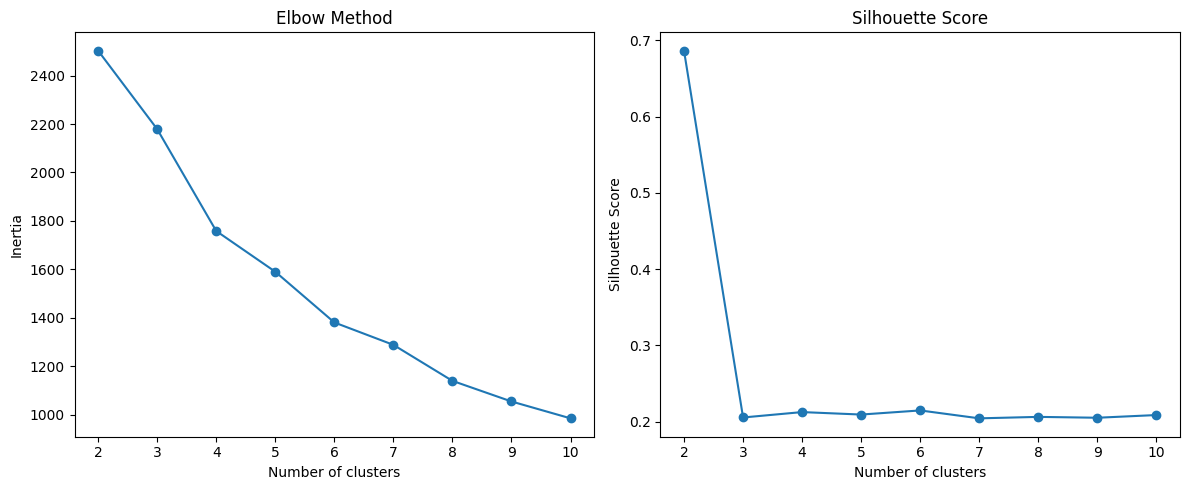

In [9]:

 
df = pd.read_csv("neuron_response_features.csv")

# Drop non-numeric columns ( we don't need the neuron_id)
features = df.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# Elbow and Silhouette
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



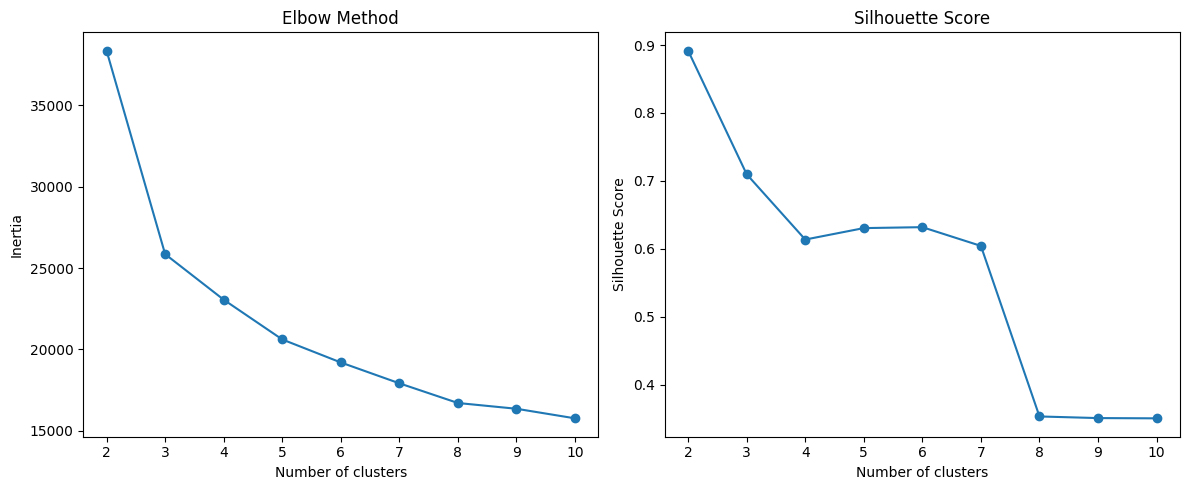

In [10]:

df = pd.read_csv("neuron_responses_raw.csv")

# Drop non-numeric columns ( we don't need the neuron_id)
features = df.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# Elbow and Silhouette
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

c:\Users\aleja\anaconda3\envs\malawi\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\aleja\anaconda3\envs\malawi\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



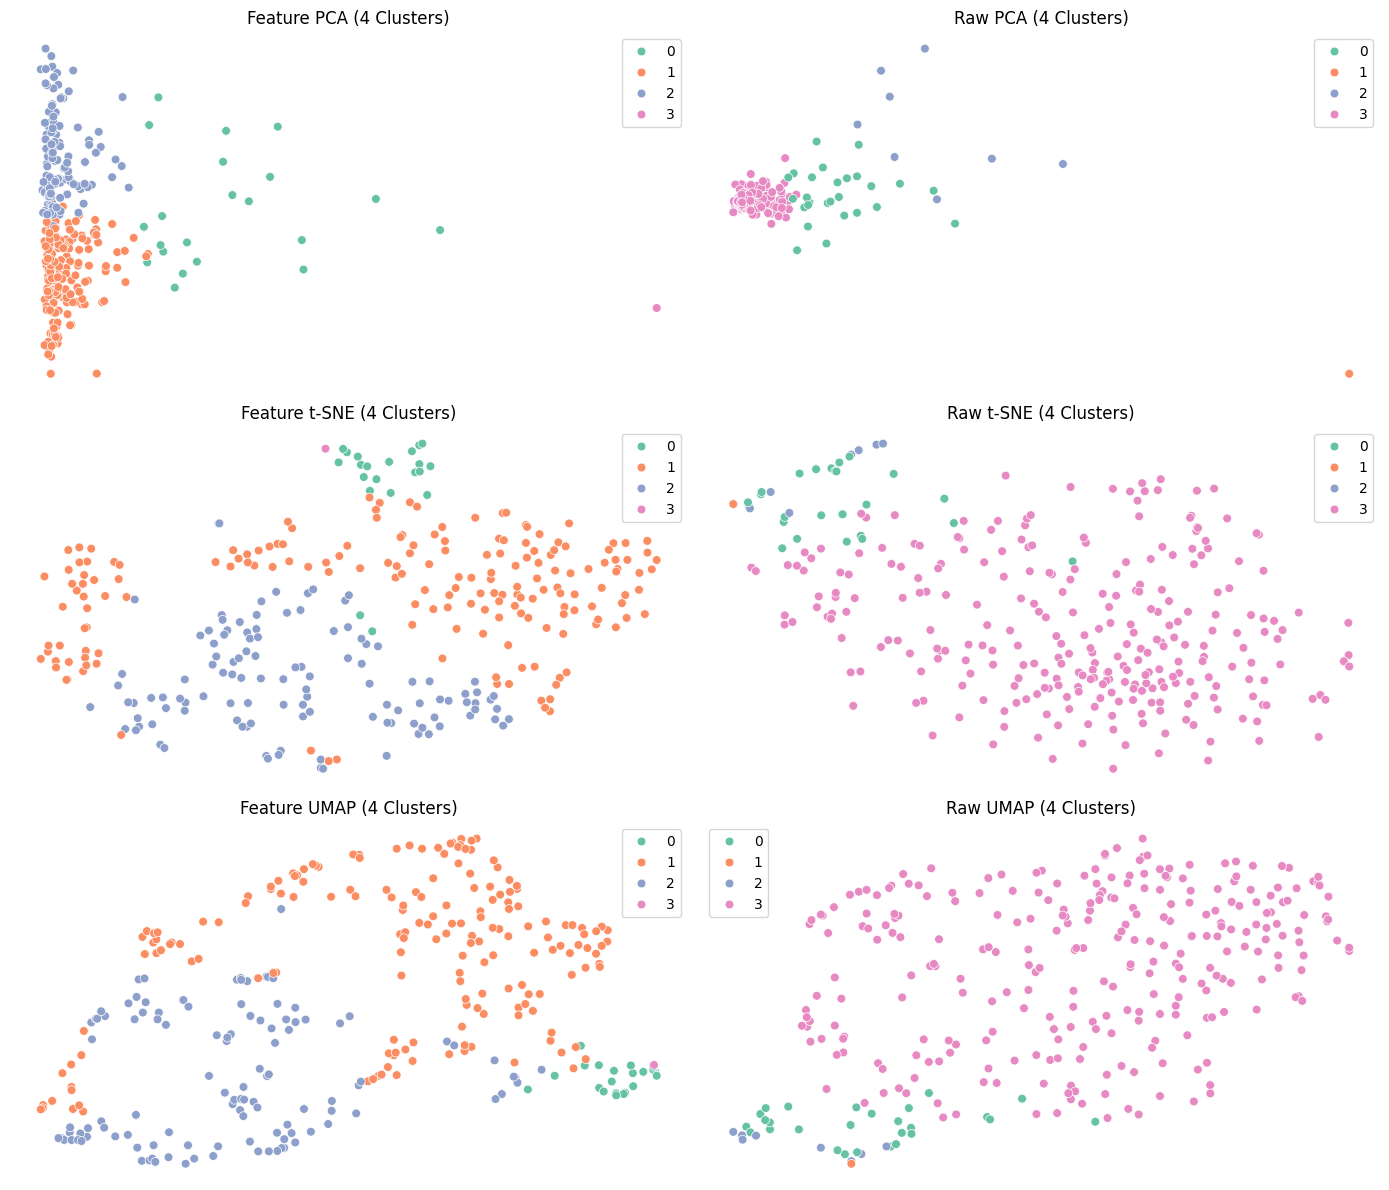

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare and standardize datasets
feature_data = summary_df.drop(columns=['neuron_id'])
raw_data = raw_df.drop(columns=['neuron_id'])

scaler_feat = StandardScaler()
X_feat = scaler_feat.fit_transform(feature_data)

scaler_raw = StandardScaler()
X_raw = scaler_raw.fit_transform(raw_data)

# Apply dimensionality reduction
pca_feat = PCA(n_components=2).fit_transform(X_feat)
tsne_feat = TSNE(n_components=2, random_state=42).fit_transform(X_feat)
umap_feat = umap.UMAP(random_state=42).fit_transform(X_feat)

pca_raw = PCA(n_components=2).fit_transform(X_raw)
tsne_raw = TSNE(n_components=2, random_state=42).fit_transform(X_raw)
umap_raw = umap.UMAP(random_state=42).fit_transform(X_raw)

# Apply KMeans clustering (default to 4 clusters)
kmeans_feat = KMeans(n_clusters=4, random_state=42).fit(X_feat)
kmeans_raw = KMeans(n_clusters=4, random_state=42).fit(X_raw)

# Add cluster labels to datasets
summary_df['cluster'] = kmeans_feat.labels_
raw_df['cluster'] = kmeans_raw.labels_

# Plotting function
def plot_embeddings(embeddings, labels, title, ax):
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, palette='Set2', s=40, ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Create plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
plot_embeddings(pca_feat, kmeans_feat.labels_, "Feature PCA (4 Clusters)", axes[0, 0])
plot_embeddings(pca_raw, kmeans_raw.labels_, "Raw PCA (4 Clusters)", axes[0, 1])
plot_embeddings(tsne_feat, kmeans_feat.labels_, "Feature t-SNE (4 Clusters)", axes[1, 0])
plot_embeddings(tsne_raw, kmeans_raw.labels_, "Raw t-SNE (4 Clusters)", axes[1, 1])
plot_embeddings(umap_feat, kmeans_feat.labels_, "Feature UMAP (4 Clusters)", axes[2, 0])
plot_embeddings(umap_raw, kmeans_raw.labels_, "Raw UMAP (4 Clusters)", axes[2, 1])

plt.tight_layout()
plt.show()


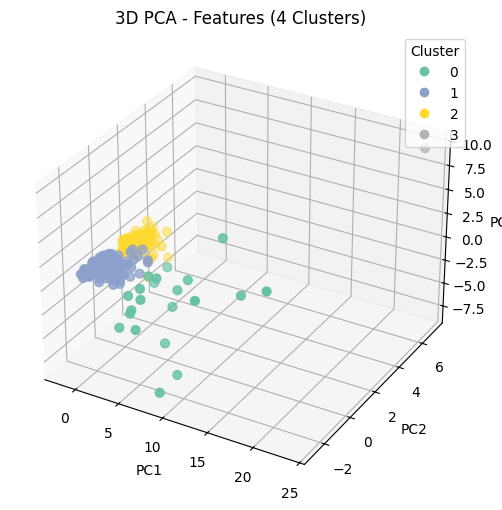

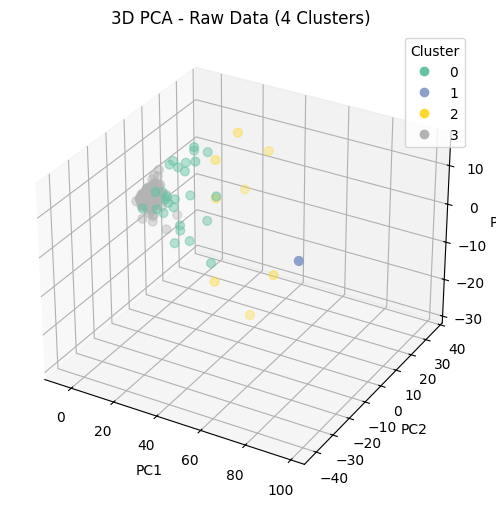

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load your data
summary_df_df = pd.read_csv("neuron_response_features.csv")
raw_df = pd.read_csv("neuron_responses_raw.csv")

# Preprocessing
X_feat = StandardScaler().fit_transform(summary_df.drop(columns=['neuron_id']))
X_raw = StandardScaler().fit_transform(raw_df.drop(columns=['neuron_id']))

# 3D PCA
pca_feat = PCA(n_components=3).fit_transform(X_feat)
pca_raw = PCA(n_components=3).fit_transform(X_raw)

# KMeans clustering
kmeans_feat = KMeans(n_clusters=4, random_state=42).fit(X_feat)
kmeans_raw = KMeans(n_clusters=4, random_state=42).fit(X_raw)

# 3D plotting function
def plot_3d(embedding, labels, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                         c=labels, cmap='Set2', s=40)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.show()

# Plot clusters
plot_3d(pca_feat, kmeans_feat.labels_, "3D PCA - Features (4 Clusters)")
plot_3d(pca_raw, kmeans_raw.labels_, "3D PCA - Raw Data (4 Clusters)")


c:\Users\aleja\anaconda3\envs\malawi\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\aleja\anaconda3\envs\malawi\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



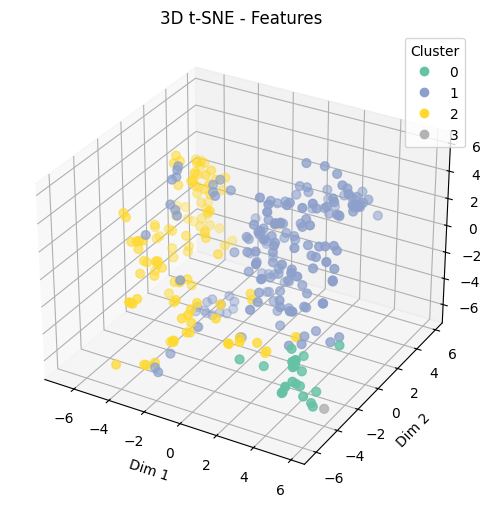

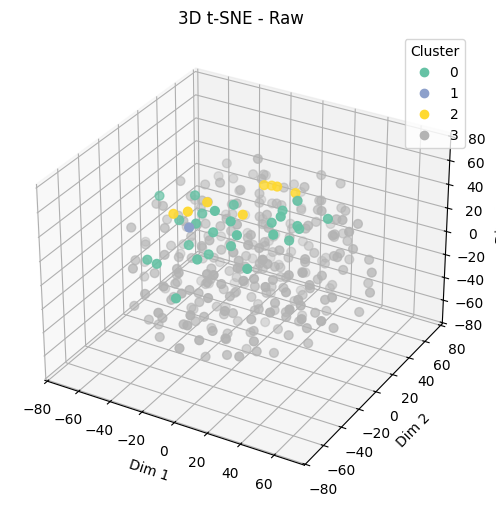

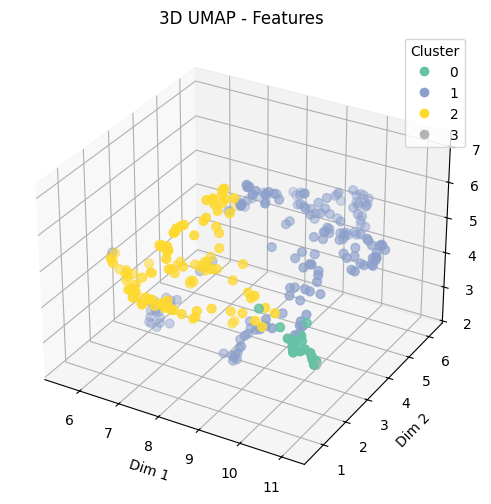

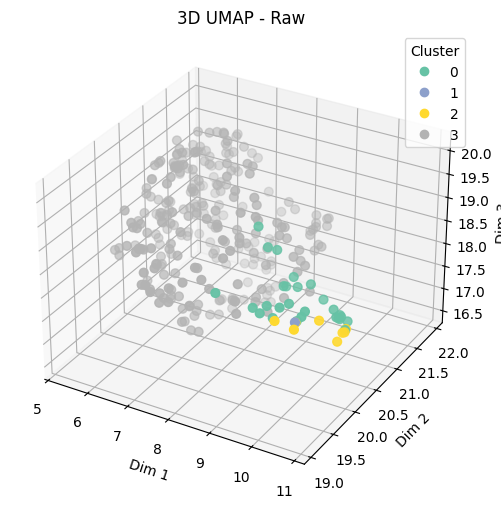

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Load and scale data
features_df = pd.read_csv("neuron_response_features.csv")
raw_df = pd.read_csv("neuron_responses_raw.csv")

X_feat = StandardScaler().fit_transform(features_df.drop(columns=['neuron_id']))
X_raw = StandardScaler().fit_transform(raw_df.drop(columns=['neuron_id']))

# Optional: PCA reduction before t-SNE/UMAP
X_raw_pca50 = PCA(n_components=50).fit_transform(X_raw)

# 3D t-SNE and UMAP
tsne_feat_3d = TSNE(n_components=3, random_state=42).fit_transform(X_feat)
tsne_raw_3d = TSNE(n_components=3, random_state=42).fit_transform(X_raw_pca50)
umap_feat_3d = umap.UMAP(n_components=3, random_state=42).fit_transform(X_feat)
umap_raw_3d = umap.UMAP(n_components=3, random_state=42).fit_transform(X_raw)

# Clustering
kmeans_feat = KMeans(n_clusters=4, random_state=42).fit(X_feat)
kmeans_raw = KMeans(n_clusters=4, random_state=42).fit(X_raw)

# Plotting function
def plot_3d(data, labels, title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c=labels, cmap='Set2', s=40)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_zlabel("Dim 3")
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.show()

# Visualize
plot_3d(tsne_feat_3d, kmeans_feat.labels_, "3D t-SNE - Features")
plot_3d(tsne_raw_3d, kmeans_raw.labels_, "3D t-SNE - Raw")
plot_3d(umap_feat_3d, kmeans_feat.labels_, "3D UMAP - Features")
plot_3d(umap_raw_3d, kmeans_raw.labels_, "3D UMAP - Raw")


In [16]:
import pandas as pd
import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = 'browser' 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans

# Load data
features_df = pd.read_csv("neuron_response_features.csv")
raw_df = pd.read_csv("neuron_responses_raw.csv")

# Prepare
X_feat = StandardScaler().fit_transform(features_df.drop(columns=["neuron_id"]))
X_raw = StandardScaler().fit_transform(raw_df.drop(columns=["neuron_id"]))
X_raw_pca50 = PCA(n_components=50).fit_transform(X_raw)

# Clustering
kmeans_feat = KMeans(n_clusters=4, random_state=42).fit(X_feat)
kmeans_raw = KMeans(n_clusters=4, random_state=42).fit(X_raw)

# Dimensionality reduction
tsne_feat = TSNE(n_components=3, random_state=42).fit_transform(X_feat)
tsne_raw = TSNE(n_components=3, random_state=42).fit_transform(X_raw_pca50)
umap_feat = umap.UMAP(n_components=3, random_state=42).fit_transform(X_feat)
umap_raw = umap.UMAP(n_components=3, random_state=42).fit_transform(X_raw)

# Create interactive 3D plot
def plot_3d_plotly(embedding, labels, title):
    df = pd.DataFrame(embedding, columns=["x", "y", "z"])
    df["cluster"] = labels
    fig = px.scatter_3d(df, x="x", y="y", z="z", color=df["cluster"].astype(str),
                        title=title, width = 1000, height = 800, labels={"color": "Cluster"})
    fig.update_traces(marker=dict(size=5))
    fig.show()

# Run visualizations
plot_3d_plotly(tsne_feat, kmeans_feat.labels_, "3D t-SNE - Features")
plot_3d_plotly(tsne_raw, kmeans_raw.labels_, "3D t-SNE - Raw")
plot_3d_plotly(umap_feat, kmeans_feat.labels_, "3D UMAP - Features")
plot_3d_plotly(umap_raw, kmeans_raw.labels_, "3D UMAP - Raw")

fig.show()

c:\Users\aleja\anaconda3\envs\malawi\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\aleja\anaconda3\envs\malawi\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



C:\Users\aleja\AppData\Local\Temp\ipykernel_25276\1156308098.py:45: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



This shows us that we can get 4 clusters, but we don't really know about what these clusters represent. 

Let's check